In [1]:
import pandas as pd
import os
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
from scipy import stats
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
from statsmodels.sandbox.stats.multicomp import TukeyHSDResults
from sklearn.metrics import roc_curve
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import pickle
import random
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)



## Cargamos dataset

In [2]:
ds = pd.read_csv('./musk.data', header = None)
# Quitamos las dos primeras columnas ya que son nombres simbólicos
ds = ds.drop([0,1], axis=1)

In [3]:
ds.columns -= 2

In [4]:
output = ds.shape[1]-1 # Columna de output
y = ds[output].values
X = ds.drop(output,axis=1).values
seed = 42
random.seed(seed)
np.random.seed(seed)

## Preprocesado de datos

**Comprobamos que no haya "missing values"**  
Según https://archive.ics.uci.edu/ml/datasets, no tiene Missing Values.

**Comprobamos que no haya variables con "near-zero variance"**  
Vemos que no hay ninguna.

In [5]:
ds.columns[ds.std() < 0.001]

Int64Index([], dtype='int64')

**Comprobamos que las clases no estén desbalanceadas**  
Están desbalanceadas. Como trabajo futuro podríamos hacer oversampling o undersampling.

In [6]:
print('Proporción clase 0: ',np.mean(y==0))
print('Proporción clase 1: ',np.mean(y==1))

Proporción clase 0:  0.8458623825401637
Proporción clase 1:  0.1541376174598363


**Estandarizamos los datos**

In [7]:
X = (X - np.mean(X)) / np.std(X)

**Desordenamos los datos**

In [8]:
X,y = shuffle(X,y)

## Entrenamiento de Modelos

**kFold - Decision Tree Classifier**

In [9]:
def exec_DT():
    global resultados_train
    global resultados_test
    global res_train
    global res_test
    global model
    global train_indices
    global test_indices
    global etiquetas
    etiquetas.extend(['DT Normal',
                 'DT Profundidad',
                 'DT Minimo de muestras por hoja',
                 'DT Minimo de muestras en subarbol',
                 'DT Minimo de impureza',
                 'LDA lsqr',
                 'LDA eigen',
                 'LDA svd',
                 'QDA'])
    dicc = [{'max_depth': None, 'min_samples_leaf': 1, 
             'min_samples_split': 2, 'min_impurity_decrease': 0.0},
            {'max_depth': 5,    'min_samples_leaf': 1, 
             'min_samples_split': 2, 'min_impurity_decrease': 0.0},
            {'max_depth': None, 'min_samples_leaf': 3, 
             'min_samples_split': 2, 'min_impurity_decrease': 0.0},
            {'max_depth': None, 'min_samples_leaf': 1, 
             'min_samples_split': 5, 'min_impurity_decrease': 0.0},
            {'max_depth': None, 'min_samples_leaf': 1, 
             'min_samples_split': 2, 'min_impurity_decrease': 0.2}]

    for i in range(len(dicc)):
        train_indices2 = []
        test_indices2 = []
        for j in range(3):
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index],X[test_index]
                y_train, y_test = y[train_index],y[test_index]
                train_indices2.append(train_index)
                test_indices2.append(test_index)
                alg = DecisionTreeClassifier(**dicc[i])
                alg.fit(X_train, y_train)
                model.append(alg)
                resultados_train.append(alg.score(X_train, y_train))
                resultados_test.append(alg.score(X_test, y_test))
        res_train = np.hstack((res_train, np.array(resultados_train,ndmin=2).T))
        res_test = np.hstack((res_test, np.array(resultados_test,ndmin=2).T))
        resultados_train = []
        resultados_test = []
        train_indices.append(train_indices2)
        test_indices.append(test_indices2)

**kFold - Linear Discriminant Analysis**

In [10]:
def exec_LDC():
    global resultados_train
    global resultados_test
    global res_train
    global res_test
    global model
    global train_indices
    global test_indices
    for tipo in ('lsqr', 'eigen', 'svd'):
        train_indices2 = []
        test_indices2 = []
        for _ in range(3):
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index],X[test_index]
                y_train, y_test = y[train_index],y[test_index]
                alg = LinearDiscriminantAnalysis(solver=tipo, shrinkage=None)
                train_indices2.append(train_index)
                test_indices2.append(test_index)
                alg.fit(X_train, y_train)
                model.append(alg)
                resultados_train.append(alg.score(X_train, y_train))
                resultados_test.append(alg.score(X_test, y_test))
        res_train = np.hstack((res_train, np.array(resultados_train,ndmin=2).T))
        res_test = np.hstack((res_test, np.array(resultados_test,ndmin=2).T))
        resultados_train = []
        resultados_test = []
        train_indices.append(train_indices2)
        test_indices.append(test_indices2)

**kFold - Quadratic Discriminant Analysis**

In [11]:
def exec_QDA():
    global resultados_train
    global resultados_test
    global res_train
    global res_test
    global model
    global train_indices
    global test_indices
    train_indices2 = []
    test_indices2 = []
    for _ in range(3):
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index],X[test_index]
            y_train, y_test = y[train_index],y[test_index]
            train_indices2.append(train_index)
            test_indices2.append(test_index)
            alg = QuadraticDiscriminantAnalysis()
            alg.fit(X_train, y_train)
            model.append(alg)
            resultados_train.append(alg.score(X_train, y_train))
            resultados_test.append(alg.score(X_test, y_test))
    res_train = np.hstack((res_train, np.array(resultados_train,ndmin=2).T))
    res_test = np.hstack((res_test, np.array(resultados_test,ndmin=2).T))
    resultados_train = []
    resultados_test = []
    train_indices.append(train_indices2)
    test_indices.append(test_indices2)

**kFold - Support Vector Classification**

In [12]:
def exec_SVC():
    global resultados_train
    global resultados_test
    global res_train
    global res_test
    global model
    global train_indices
    global test_indices
    global etiquetas
    etiquetas.extend(['SVM poly 2º C1',
                 'SVM poly 3º C1',
                 'SVM poly 4º C1',
                 'SVM rfb auto C1',
                 'SVM rfb 0.05 C1',
                 'SVM rfb 0.1 C1',
                 'SVM rfb 0.2 C1'])
    # etiquetas.extend(['SVM linear C100',
    #              'SVM poly 2º C100',
    #              'SVM poly 3º C100',
    #              'SVM poly 4º C100',
    #              'SVM rfb auto C100',
    #              'SVM rfb 0.05 C100',
    #              'SVM rfb 0.1 C100',
    #              'SVM rfb 0.2 C100'])
    dicc = [{'C': 1.0, 'kernel': 'poly', 'degree': 2, 
             'gamma': 'auto', 'class_weight': 'balanced'},
            {'C': 1.0, 'kernel': 'poly', 'degree': 3, 
             'gamma': 'auto', 'class_weight': 'balanced'},
            {'C': 1.0, 'kernel': 'poly', 'degree': 4, 
             'gamma': 'auto', 'class_weight': 'balanced'},
            {'C': 1.0, 'kernel': 'rbf', 'degree': 2,  
             'gamma': 'auto', 'class_weight': 'balanced'},
            {'C': 1.0, 'kernel': 'rbf', 'degree': 2,  
             'gamma': 0.05, 'class_weight': 'balanced'},
            {'C': 1.0, 'kernel': 'rbf', 'degree': 2,  
             'gamma': 0.1, 'class_weight': 'balanced'},
            {'C': 1.0, 'kernel': 'rbf', 'degree': 2,  
             'gamma': 0.2, 'class_weight': 'balanced'}]

    for i in range(len(dicc)):
        train_indices2 = []
        test_indices2 = []
        for j in range(3):
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index],X[test_index]
                y_train, y_test = y[train_index],y[test_index]
                train_indices2.append(train_index)
                test_indices2.append(test_index)
                alg = SVC(**dicc[i])
                alg.fit(X_train, y_train)
                model.append(alg)
                resultados_train.append(alg.score(X_train, y_train))
                resultados_test.append(alg.score(X_test, y_test))
        res_train = np.hstack((res_train, np.array(resultados_train,ndmin=2).T))
        res_test = np.hstack((res_test, np.array(resultados_test,ndmin=2).T))
        resultados_train = []
        resultados_test = []
        train_indices.append(train_indices2)
        test_indices.append(test_indices2)

**kFold - Multi-layer Perceptron Classifier**

In [13]:
def exec_MLPC():
    global resultados_train
    global resultados_test
    global res_train
    global res_test
    global model
    global train_indices
    global test_indices
    global etiquetas
    etiquetas.extend(['MLPR sgd 10 relu',
                 'MLPR sgd 30 relu',
                 'MLPR sgd 50 relu',
                 'MLPR adam 10 relu',
                 'MLPR adam 30 relu',
                 'MLPR adam 50 relu'])
    etiquetas.extend(['MLPR sgd 10 tanh',
                 'MLPR sgd 30 tanh',
                 'MLPR sgd 50 tanh',
                 'MLPR adam 10 tanh',
                 'MLPR adam 30 tanh',
                 'MLPR adam 50 tanh'])
    dicc = [{'hidden_layer_sizes': (10,), 'solver': 'sgd',  
             'activation': 'relu','early_stopping': True, 'max_iter': 1500},
            {'hidden_layer_sizes': (30,), 'solver': 'sgd',  
             'activation': 'relu','early_stopping': True, 'max_iter': 1500},
            {'hidden_layer_sizes': (50,), 'solver': 'sgd',  
             'activation': 'relu','early_stopping': True, 'max_iter': 1500},
            {'hidden_layer_sizes': (10,), 'solver': 'adam', 
             'activation': 'relu','early_stopping': True, 'max_iter': 1500},
            {'hidden_layer_sizes': (30,), 'solver': 'adam', 
             'activation': 'relu','early_stopping': True, 'max_iter': 1500},
            {'hidden_layer_sizes': (50,), 'solver': 'adam', 
             'activation': 'relu','early_stopping': True, 'max_iter': 1500},
            {'hidden_layer_sizes': (10,), 'solver': 'sgd',  
             'activation': 'tanh','early_stopping': True, 'max_iter': 1500},
            {'hidden_layer_sizes': (30,), 'solver': 'sgd',  
             'activation': 'tanh','early_stopping': True, 'max_iter': 1500},
            {'hidden_layer_sizes': (50,), 'solver': 'sgd',  
             'activation': 'tanh','early_stopping': True, 'max_iter': 1500},
            {'hidden_layer_sizes': (10,), 'solver': 'adam', 
             'activation': 'tanh','early_stopping': True, 'max_iter': 1500},
            {'hidden_layer_sizes': (30,), 'solver': 'adam', 
             'activation': 'tanh','early_stopping': True, 'max_iter': 1500},
            {'hidden_layer_sizes': (50,), 'solver': 'adam', 
             'activation': 'tanh','early_stopping': True, 'max_iter': 1500}]

    for i in range(len(dicc)):
        train_indices2 = []
        test_indices2 = []
        for j in range(3):
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index],X[test_index]
                y_train, y_test = y[train_index],y[test_index]
                train_indices2.append(train_index)
                test_indices2.append(test_index)
                alg = MLPClassifier(**dicc[i])
                alg.fit(X_train, y_train)
                model.append(alg)
                resultados_train.append(alg.score(X_train, y_train))
                resultados_test.append(alg.score(X_test, y_test))
        res_train = np.hstack((res_train, np.array(resultados_train,ndmin=2).T))
        res_test = np.hstack((res_test, np.array(resultados_test,ndmin=2).T))
        resultados_train = []
        resultados_test = []
        train_indices.append(train_indices2)
        test_indices.append(test_indices2)

In [39]:
# Definición de variables globales
kf = KFold(n_splits=10,shuffle=True)
resultados_train = []
resultados_test = []
model = []
res_train = np.empty((30,0))
res_test = np.empty((30,0))
train_indices = []
test_indices = []
etiquetas = []
# Ejecuciones
print('Decision Tree Classifier')
%time exec_DT()
print('Lineal Discriminant Analysis')
%time exec_LDC()
print('Quadratic Discriminant Analysis')
%time exec_QDA()
print('Support Vector Classification')
%time exec_SVC()
print('Multi-layer Perceptron Classifier')
%time exec_MLPC()

Decision Tree Classifier
Wall time: 1min
Lineal Discriminant Analysis
Wall time: 17.3 s
Quadratic Discriminant Analysis
Wall time: 4.64 s
Support Vector Classification
Wall time: 26min 54s
Multi-layer Perceptron Classifier
Wall time: 10min 59s


**Persistencia**

In [40]:
with open('p3_musk-res_test.bin','wb') as file:
    pickle.dump(res_test, file)
with open('p3_musk-train_indices.bin','wb') as file:
    pickle.dump(train_indices, file)
with open('p3_musk-test_indices.bin','wb') as file:
    pickle.dump(test_indices, file)
with open('p3_musk-models.bin','wb') as file:
    pickle.dump(model, file)
with open('p3_musk-etiquetas.bin','wb') as file:
    pickle.dump(etiquetas, file)

In [19]:
with open('p3_musk-res_test.bin','rb') as file:
    res_test = pickle.load(file)
with open('p3_musk-train_indices.bin','rb') as file:
    train_indices = pickle.load(file)
with open('p3_musk-test_indices.bin','rb') as file:
    test_indices = pickle.load(file)
with open('p3_musk-models.bin','rb') as file:
    model = pickle.load(file)
with open('p3_musk-etiquetas.bin','rb') as file:
    etiquetas = pickle.load(file)

**Test de normalidad**  
No podemos rechazamos normalidad en el 85% de los modelos, por lo que realizamos un ANOVA (y Kruskal-Wallis para asegurarnos) 

In [20]:
np.apply_along_axis(lambda x: stats.shapiro(x)[1], axis=0, arr=res_test)

array([6.41781330e-01, 3.56934547e-01, 2.37274349e-01, 4.06896681e-01,
       8.24977636e-01, 4.31955099e-01, 1.30944937e-01, 5.28166413e-01,
       6.92675471e-01, 2.70530045e-01, 7.15229809e-01, 1.26872808e-01,
       9.17859852e-01, 4.87028271e-01, 6.31274432e-02, 2.79743969e-01,
       9.27778965e-05, 9.27439153e-01, 7.47246265e-01, 3.23169589e-01,
       3.39797605e-03, 3.12038435e-04, 5.69412351e-01, 9.11463380e-01,
       7.10717142e-02, 5.97309768e-02, 3.80838737e-02, 5.88941574e-02])

**Test Anova**  
Rechazamos que las precisiones sean similares

In [21]:
print(stats.f_oneway(*zip(*list(res_test))))

F_onewayResult(statistic=350.0213105964739, pvalue=0.0)


**Test de Kruskal-Wallis**  
Rechazamos que las precisiones sean similares

In [22]:
print(stats.kruskal(*zip(*list(res_test))))

KruskalResult(statistic=736.9516537594691, pvalue=6.837641730953702e-138)


In [23]:
labels = [etiquetas[i] for i in range(res_test.shape[1]) for _ in range(res_test.shape[0])]
arr_test = res_test.flatten('F')
resultados = pairwise_tukeyhsd(arr_test,labels)
# resultados.summary()

In [24]:
#seleccionamos el que tiene mejor media y vemos en el anterior cuales son iguales
best_group = np.argmax(np.mean(res_test, axis = 0))
best_group = etiquetas[int(best_group)]

Figure(720x432)


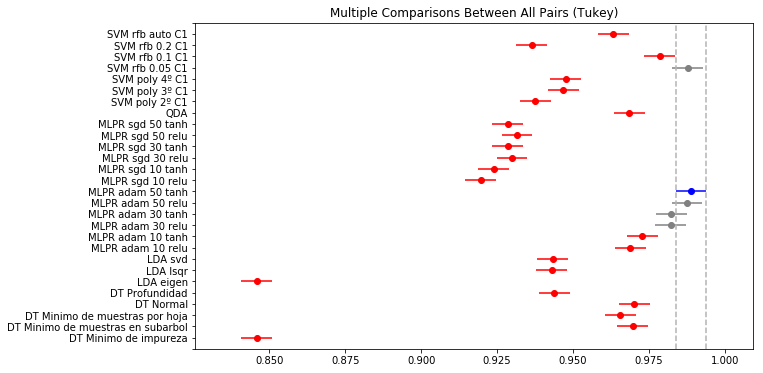

In [25]:
print(resultados.plot_simultaneous(comparison_name=best_group))

In [26]:
resultados = resultados._results_table.data

In [27]:
group1 = resultados[0].index('group1')
group2 = resultados[0].index('group2')
reject = resultados[0].index('reject')
best_groups = []
for row in resultados[1:]:
    if (row[group1] == str(best_group) or row[group2] == str(best_group)) and not row[reject]:
        best_groups.append(row[group1])
        best_groups.append(row[group2])
best_groups.append(best_group)
best_groups = set(best_groups)
sorted(best_groups)

['MLPR adam 30 relu',
 'MLPR adam 30 tanh',
 'MLPR adam 50 relu',
 'MLPR adam 50 tanh',
 'SVM rfb 0.05 C1']

In [28]:
def performance_indexes(CM, PositiveClass):
    classNum = len(CM)
    TP = CM[PositiveClass, PositiveClass]
    TN = 0
    FP = 0
    FN = 0
    for real in range(classNum):
        for predicted in range(classNum):
            if (real != PositiveClass and predicted != PositiveClass):
                TN += CM[real, predicted]
            if (real != PositiveClass and predicted == PositiveClass):
                FP += CM[real, predicted]
            if (real == PositiveClass and predicted != PositiveClass):
                FN += CM[real, predicted]
    Sens = TP/(TP+FN)
    Spec = TN/(TN+FP)
    PPV = TP/(TP+FP)
    NPV = TN/(TN+FN)
    ACC = (TP+TN)/(TP+TN+FP+FN)
    return Sens,Spec,PPV,NPV,ACC

In [29]:
for etiqueta in sorted(best_groups):
    i = etiquetas.index(etiqueta)
    m_min = i*30
    m_max = (i+1)*30
    current_model = model[m_min:m_max]
    Sens_l = []
    Spec_l = []
    PPV_l = []
    NPV_l = []
    ACC_l = []
    for idx, test_index in enumerate(test_indices[i]):
        X_test, y_test = X[test_index], y[test_index]
        y_pred = current_model[idx].predict(X_test)
        CM = confusion_matrix(y_test, y_pred)
        Sens,Spec,PPV,NPV,ACC = performance_indexes(CM,1)
        Sens_l.append(Sens)
        Spec_l.append(Spec)
        PPV_l.append(PPV)
        NPV_l.append(NPV)
        ACC_l.append(ACC)
    print(etiqueta,('-> Sens: {:.2f} +- {:.2f}, Spec: {:.2f} +- {:.2f}, ' +
           'PPV: {:.2f} +- {:.2f}, NPV: {:.2f} +- {:.2f}, ACC: {:.2f} +- {:.2f}').format(
        np.mean(Sens_l), np.std(Sens_l),
        np.mean(Spec_l), np.std(Spec_l),
        np.mean(PPV_l), np.std(PPV_l),
        np.mean(NPV_l), np.std(NPV_l),
        np.mean(ACC_l), np.std(ACC_l)))

MLPR adam 30 relu -> Sens: 0.92 +- 0.06, Spec: 0.99 +- 0.00, PPV: 0.96 +- 0.02, NPV: 0.99 +- 0.01, ACC: 0.98 +- 0.01
MLPR adam 30 tanh -> Sens: 0.92 +- 0.05, Spec: 0.99 +- 0.00, PPV: 0.96 +- 0.03, NPV: 0.99 +- 0.01, ACC: 0.98 +- 0.01
MLPR adam 50 relu -> Sens: 0.95 +- 0.05, Spec: 0.99 +- 0.00, PPV: 0.97 +- 0.02, NPV: 0.99 +- 0.01, ACC: 0.99 +- 0.01
MLPR adam 50 tanh -> Sens: 0.95 +- 0.03, Spec: 1.00 +- 0.00, PPV: 0.97 +- 0.02, NPV: 0.99 +- 0.01, ACC: 0.99 +- 0.01
SVM rfb 0.05 C1 -> Sens: 0.97 +- 0.02, Spec: 0.99 +- 0.00, PPV: 0.95 +- 0.02, NPV: 0.99 +- 0.00, ACC: 0.99 +- 0.00


**Escogemos el modelo SVM rbf con gamma = 0.05 como el más sencillo de los mejores**

----------------------------------------------------------------------------------------------------------------------------

In [26]:
for ind, tag in enumerate(etiquetas):
    mean_test = np.mean(res_test[:,ind])
    std_test = np.std(res_test[:,ind])
    print('{}: {:.2f} +- {:.2f}'.format(tag, mean_test, std_test))

DT Normal: 0.97 +- 0.01
DT Profundidad: 0.94 +- 0.01
DT Minimo de muestras por hoja: 0.97 +- 0.01
DT Minimo de muestras en subarbol: 0.97 +- 0.01
DT Minimo de impureza: 0.85 +- 0.01
LDA lsqr: 0.94 +- 0.01
LDA eigen: 0.85 +- 0.01
LDA svd: 0.94 +- 0.01
QDA: 0.97 +- 0.01
SVM poly 2º C1: 0.94 +- 0.01
SVM poly 3º C1: 0.95 +- 0.01
SVM poly 4º C1: 0.95 +- 0.01
SVM rfb auto C1: 0.96 +- 0.01
SVM rfb 0.05 C1: 0.99 +- 0.00
SVM rfb 0.1 C1: 0.98 +- 0.01
SVM rfb 0.2 C1: 0.94 +- 0.01
MLPR sgd 10 relu: 0.92 +- 0.02
MLPR sgd 30 relu: 0.93 +- 0.01
MLPR sgd 50 relu: 0.93 +- 0.01
MLPR adam 10 relu: 0.97 +- 0.01
MLPR adam 30 relu: 0.98 +- 0.01
MLPR adam 50 relu: 0.99 +- 0.01
MLPR sgd 10 tanh: 0.92 +- 0.01
MLPR sgd 30 tanh: 0.93 +- 0.01
MLPR sgd 50 tanh: 0.93 +- 0.01
MLPR adam 10 tanh: 0.97 +- 0.01
MLPR adam 30 tanh: 0.98 +- 0.01
MLPR adam 50 tanh: 0.99 +- 0.01


## FIN